## 09-네이버 영화 리뷰 분류

In [1]:
# 필요한 패키지 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# 데이터 로드하기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [3]:
# 훈련데이터 확인
print('훈련용 리뷰 개수: ', len(test_data))

# 상위 5개 출력
test_data.head()

훈련용 리뷰 개수:  50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [4]:
# 데이터별 중복 확인
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [5]:
# document 컬럼에 대한 중복 데이터 제거
train_data.drop_duplicates(subset = ['document'], inplace = True)
print('총 샘플의 수: ', len(train_data))

총 샘플의 수:  146183


<AxesSubplot:>

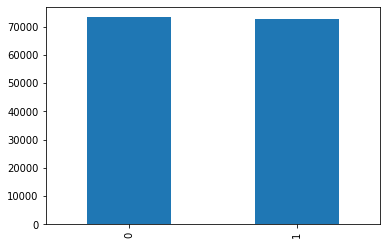

In [6]:
# 각 리뷰별로 긍정과 부정 비율 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [7]:
# 각 리뷰별로 긍정과 부정의 정확한 수치 확인
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,73342
1,1,72841


In [8]:
# 결측치 데이터 확인
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [9]:
# 어떤 리뷰가 비어 있는지 정확하게 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [10]:
# null데이터를 갖는 행 삭제
train_data = train_data.dropna(how = 'any')
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [11]:
# 정규표현식 사용하여 리뷰글에 한글과 공백만 남겨두고 나머지 제거
# -> 영문으로만 작성된 리뷰는 빈 문자열로 변경됨
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')

In [12]:
# 빈 문자열값은 결측치로 변경
train_data['document'].replace('', np.nan, inplace = True)
train_data.isnull().sum()

id            0
document    391
label         0
dtype: int64

In [13]:
# 다시 결측치 데이터 삭제
train_data = train_data.dropna(how = 'any')
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [14]:
# 같은 과정을 테스트 데이터에도 적용
# document 열에서 중복인 내용이 있다면 중복 제거
test_data.drop_duplicates(subset = ['document'], inplace = True)

# 정규표현식 진행
test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')

# 공백은 null 값으로 변경
test_data['document'].replace('', np.nan, inplace = True)
test_data = test_data.dropna(how = 'any')
print('전처리 후 테스트용 샘플의 개수: ', len(test_data))

전처리 후 테스트용 샘플의 개수:  48995


In [15]:
# 토큰화를 위한 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [16]:
# 형태소 분석 엔진 객체 생성
okt = Okt()

In [17]:
# 아래는 okt의 사용법 샘플(전체 예제와는 상관 없음)
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [18]:
X_train = []

for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem = True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)
    
# 상위 3건만 출력하여 결과 확인
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [19]:
# 테스트 데이터에 대해서 토큰화 수행
X_test = []

for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem = True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)
    
# 상위 3건만 출력하여 결과 확인
print(X_test[:3])

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


## 정수 인코딩
- 단어 집합 생성 및 인덱스 번호 부여
- 각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

- 빈도수가 낮은 단어들은 자연어 처리에서 배제
- 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 언만큼의 비중을 차지하는지 확인

In [21]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기: ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율: ', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율: ', (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기:  43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율:  55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율:  1.8715872104872904


- 등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.87%
- 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않은 듯 하다.
- 이 단어들은 정수 인코딩 과정에서 배제한다.

In [22]:
# 등장 빈도수가 2 이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기: ', vocab_size)

단어 집합의 크기:  19417


In [23]:
# 산출된 단어 집합의 크기(vocab_size)를 케라스 토크나이저의 인자로 설정
# -> 텍스트 시퀀스를 숫자 시퀀스로 변환
# -> 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20], [387, 2445, 1, 2316, 5672, 3, 223, 10]]


- 단어의 개수는 19,417개로 제한되었다.
- 0번 단어 ~ 19,416번 단어까지만 사용
- 0번 단어는 패딩을 위한 토큰, 1번 단어는 OOV를 위한 토큰
- 다시 말해, 19,417 이상의 정수는 더이상 훈련 데이터에 존재하지 않는다.

In [24]:
# train_data에서 y_train과 y_test를 별도로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플 (empty samples) 제거
- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미
- 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해주는 작업 수행
- 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아오기

In [25]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

drop_train[:3]

[404, 412, 470]

In [26]:
# 빈 샘플 제거
X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)
print(len(X_train))
print(len(y_train))

145380
145380


## 패딩
- 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업

리뷰의 최대 길이:  72
리뷰의 평균 길이:  11.002187371027652


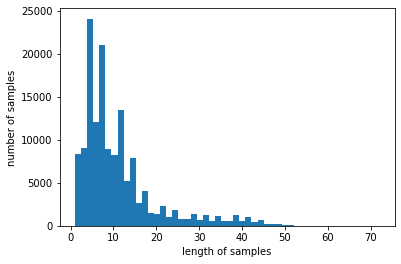

In [27]:
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포

print('리뷰의 최대 길이: ', max(len(l) for l in X_train))
print('리뷰의 평균 길이: ', sum(map(len, X_train)) / len(X_train))
plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 리뷰의 가장 긴 리뷰의 길이는 72이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 11내외의 길이
- 델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있음

In [28]:
# 특정 길이를 의미하는 변수
max_len = 30

# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list)) * 100))
    
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30이하인 샘플의 비율: 94.0830925849498


In [29]:
# 모든 샘플의 길이를 30으로 맞추기
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 모델 구성하기

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation = 'sigmoid'))

# 훈련 도중 중간 조건 설정
# --> 손실률(val_loss)의 최소값(min)이 1부터 4번 증가하면 중단
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

# 훈련 모델 저장 조건
# --> 훈련 정확도(val_acc)가 이전보다 좋아졌을 때만 저장
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

# 모델 컴파일
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1941700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,059,077
Trainable params: 2,059,077
Non-trainable params: 0
_________________________________________________________________


## 학습하기

In [31]:
history = model.fit(X_train, y_train, epochs = 15, callbacks = [es, mc], batch_size = 60, validation_split = 0.2)

Epoch 1/15
1939/1939 [==============================] - ETA: 0s - loss: 0.3916 - acc: 0.8232
Epoch 00001: val_acc improved from -inf to 0.84344, saving model to best_model.h5
1939/1939 [==============================] - 145s 75ms/step - loss: 0.3916 - acc: 0.8232 - val_loss: 0.3545 - val_acc: 0.8434
Epoch 2/15
1939/1939 [==============================] - ETA: 0s - loss: 0.3288 - acc: 0.8570
Epoch 00002: val_acc improved from 0.84344 to 0.85256, saving model to best_model.h5
1939/1939 [==============================] - 145s 75ms/step - loss: 0.3288 - acc: 0.8570 - val_loss: 0.3335 - val_acc: 0.8526
Epoch 3/15
1939/1939 [==============================] - ETA: 0s - loss: 0.3031 - acc: 0.8708
Epoch 00003: val_acc improved from 0.85256 to 0.85514, saving model to best_model.h5
1939/1939 [==============================] - 145s 75ms/step - loss: 0.3031 - acc: 0.8708 - val_loss: 0.3333 - val_acc: 0.8551
Epoch 4/15
1939/1939 [==============================] - ETA: 0s - loss: 0.2838 - acc: 0.881

## 학습 과정 확인

In [32]:
his_dict = history.history

c:\users\youjin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\youjin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\youjin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48143 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\youjin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44160 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\youjin\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51613 missing from current font.
  font.set_t

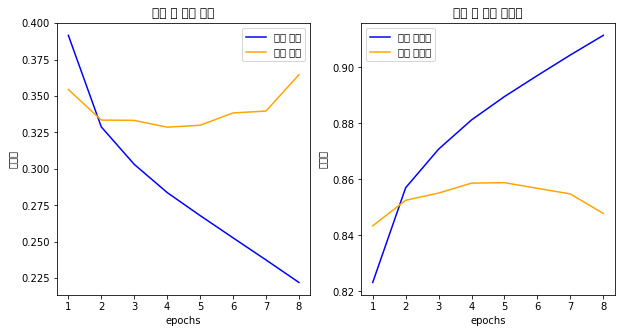

In [33]:
# 훈련 및 검증 손실 그리기
loss = his_dict['loss']
val_loss = his_dict['val_loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = '훈련 손실')
ax1.plot(epochs, val_loss, color = 'orange', label = '검증 손실')
ax1.set_title('훈련 및 검증 손실')
ax1.set_xlabel('epochs')
ax1.set_ylabel('손실률')
ax1.legend()

# 훈련 및 검증 정확도 그리기
acc = his_dict['acc']
val_acc = his_dict['val_acc']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = '훈련 정확도')
ax2.plot(epochs, val_acc, color = 'orange', label = '검증 정확도')
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('epochs')
ax2.set_ylabel('정확도')
ax2.legend()

plt.show()

## 테스트 데이터에 대한 정확도를 측정

In [34]:
loaded_model = load_model('best_model.h5')
print('\n 테스트 정확도: %.4f' %(loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 16s 10ms/step - loss: 0.3379 - acc: 0.8553

 테스트 정확도: 0.8553


In [35]:
# 리뷰 예측을 위한 함수

def sentiment_predict(new_sentence):
    # 토큰화
    new_sentence = okt.morphs(new_sentence, stem = True)
    # 불용어 제거
    new_sentence = [word for word in new_sentence if not word in stopwords]
    
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    
    result = None
    if score > 0.5:
        print('{:.2f}% 확률로 긍정 리뷰입니다. \n'.format(score * 100))
        result = 1
    else:
        print('{:.2f}f 확률로 부정 리뷰입니다. \n'.format((1-score) * 100))
        result = 0
        
    return result

In [36]:
sentiment_predict('안본눈 삽니다.')

69.98f 확률로 부정 리뷰입니다. 



0

## 네이버 영화 리뷰 수집결과 불러오기

In [37]:
review_list = []
with open('result.txt', 'r', encoding = 'utf-8') as f:
    review_list = f.readlines()
    
review_list[:3]

['B급 이하전편보다 퇴보된 CG, 중구난방식 연출, 러닝타임 늘리기 위한 쓸모없는 컷, 부족한 액션, 영화가 주는 시사점도 없고 보는 내내 오그라들고 나가고싶었음.\n',
 '이딴 영화가 평점 8점 후반대라는 게 믿기지 않는다. 역시 네이버 평점은 믿고 걸러야 한다.개연성 중요하게 생각하는 사람들은 보면서 토할 수도 있으니까 조심.중후반부터 느금마사급 전개가 계속 이어지기 때문에 정신잡기...\n',
 '역시 원더우먼 영화는 주연배우 갤가돗과 크리스파인이 다 살리네.. 감독은 확실히 영화 못 찍음.... 예전 샤를리즈 테론 영화 몬스터만해도 배우가 다 살림... 원더우먼 1도 악당 허술하고 매력없고 스토리도 전개가 ...\n']

In [44]:
# ~확률로 부정 리뷰입니다. 다른 리스트로 포함시키기

# 리뷰 예측을 위한 함수

def sentiment_predict(new_sentence):
    re_list = []
    # 토큰화
    new_sentence = okt.morphs(new_sentence, stem = True)
    # 불용어 제거
    new_sentence = [word for word in new_sentence if not word in stopwords]
    
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    
    result = None
    if score > 0.5:
        re_list.append('{:.2f}% 확률로 긍정 리뷰입니다. \n'.format(score * 100))
        result = 1
    else:
        re_list.append('{:.2f}f 확률로 부정 리뷰입니다. \n'.format((1-score) * 100))
        result = 0
        
    return result

In [45]:
review_data = []
size = len(review_list)

for i, v in enumerate(review_list):
    predict = sentiment_predict(v)
    review_dict = {'document' : v, 'label' : predict}
    review_data.append(review_dict)
    
import pandas as pd
df = pd.DataFrame(review_data)

In [46]:
df

,document,label
0,"B급 이하전편보다 퇴보된 CG, 중구난방식 연출, 러닝타임 늘리기 위한 쓸모없는 컷...",0
1,이딴 영화가 평점 8점 후반대라는 게 믿기지 않는다. 역시 네이버 평점은 믿고 걸러...,0
2,역시 원더우먼 영화는 주연배우 갤가돗과 크리스파인이 다 살리네.. 감독은 확실히 영...,0
3,진짜 개노잼이다.. 1편이랑 같은 감독맞나?러닝타임도 길어서 개지루함 ㄹㅇ\n,0
4,스포일러가 포함된 감상평입니다. 감상평 보기\n,1
...,...,...
4063,스포일러가 포함된 감상평입니다. 감상평 보기\n,1
4064,원더우먼은 강하지 못했으며악역도 강하지 못했다.내가 세상에서 제일 잘나갔으면 좋겠다.\n,0
4065,지금 하고 있는 영화 중에 유일하게 재밌어 보여서 골랐고 즐기기에 괜찮음. 여성감독...,0
4066,난 존나 재밉게 봤는데 OO들이네 이이상 어떻게 더만들어겔갓돈 그자체로 이쁨\n,1


In [47]:
# csv파일로 저장
df.to_csv('movie_reviews_RNN.csv', header = True, index = False, encoding = 'utf-8')

In [48]:
cnt = df.filter(['label']).value_counts()
cnt

label
0        2595
1        1473
dtype: int64

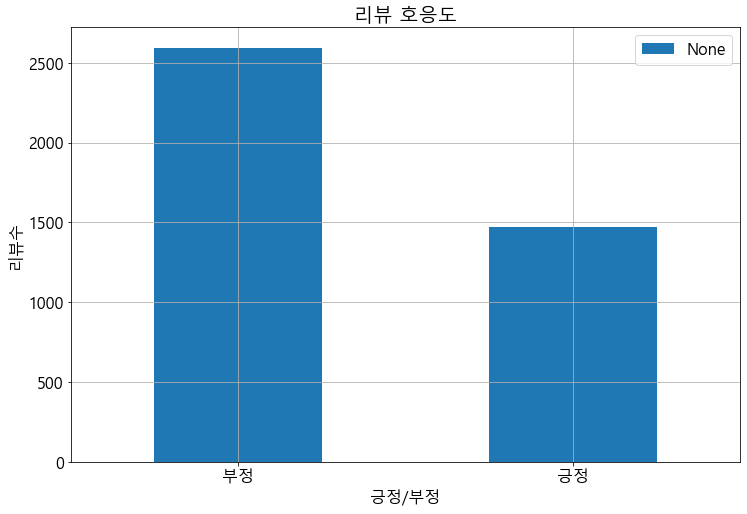

In [49]:
# 한글폰트, 그래픽 크기 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (12, 8)

cnt.plot.bar(rot = 0)
plt.grid()
plt.legend()
plt.title('리뷰 호응도')
plt.ylabel('리뷰수')
plt.xlabel('긍정/부정')
plt.xticks([0, 1], ['부정','긍정'])
plt.show()

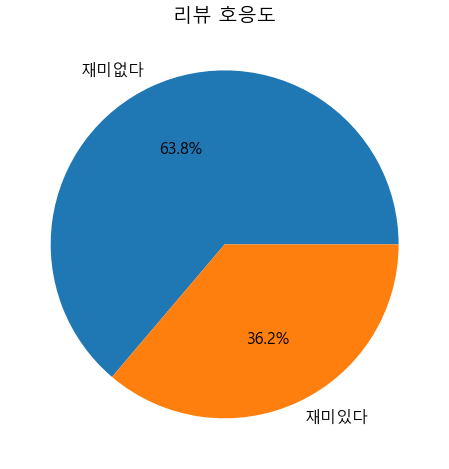

In [50]:
cnt.plot.pie(labels = ['재미없다','재미있다'], autopct = '%0.1f%%')
plt.title('리뷰 호응도')
plt.ylabel(None)
plt.show()